<a href="https://colab.research.google.com/github/jyothissJayadev/ImageRecognize/blob/main/image_recoognise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install opendatasets --upgrade --quiet

In [3]:
import opendatasets as od
import os
import shutil
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt

In [4]:
dataset_url = 'https://www.kaggle.com/alxmamaev/flowers-recognition'
if os.path.exists('./flowers-recognition'):
    shutil.rmtree('./flowers-recognition')
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: jyothisjayadevan
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/alxmamaev/flowers-recognition


100%|██████████| 225M/225M [00:02<00:00, 106MB/s]


In [5]:
data_dir = './flowers-recognition/flowers'
os.listdir(data_dir)

['daisy', 'sunflower', 'rose', 'dandelion', 'tulip']

In [6]:
for cls in os.listdir(data_dir):
    print(cls, ':', len(os.listdir(data_dir + '/' + cls)))

daisy : 764
sunflower : 733
rose : 784
dandelion : 1052
tulip : 984


In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

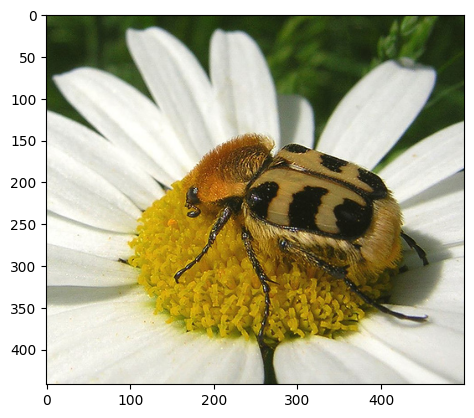

In [8]:
dataset = ImageFolder(data_dir)
img, label = dataset[120]
plt.imshow(img)

In [9]:
dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(64),
                                            tt.RandomCrop(64),
                                            tt.ToTensor()]))
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

train_size, val_size

(3886, 431)

In [10]:
from torch.utils.data import random_split

train_ds, valid_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)

(3886, 431)

In [11]:
from torch.utils.data import DataLoader

batch_size = 128

train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=4,
                      pin_memory=True)

valid_dl = DataLoader(valid_ds,
                    batch_size,
                    num_workers=4,
                    pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [12]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

In [13]:
import torch

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [14]:
device = get_default_device()
img, label = dataset[0]
img_gpu = to_device(img, device)
img_gpu.device

device(type='cuda', index=0)

In [15]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [16]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        "calculate loss for a batch of training data"
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        "calculate loss & accuracy for a batch of validation data"
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [17]:
@torch.no_grad()
def evaluate(model, val_loader):
    """Evaluates the model's performance on the validation set"""
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [18]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Input: 128 x 3 x 64 x 64
        self.conv1 = conv_block(in_channels, 64) # 128 x 64 x 64 x 64
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 128 x 32 x 32
        self.res1 = nn.Sequential(conv_block(128, 128), # 128 x 128 x 32 x 32
                                  conv_block(128, 128)) # 128 x 128 x 32 x 32

        self.conv3 = conv_block(128, 256, pool=True) # 128 x 256 x 16 x 16
        self.conv4 = conv_block(256, 512, pool=True) # 128 x 512 x 8 x 8
        self.res2 = nn.Sequential(conv_block(512, 512), # 128 x 512 x 8 x 8
                                  conv_block(512, 512)) # 128 x 512 x 8 x 8

        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 128 x 512 x 1 x 1
                                        nn.Flatten(), # 128 x 512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [19]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model.conv1[0].weight.device

device(type='cuda', index=0)

In [20]:
torch.cuda.empty_cache()
for batch in train_dl:
    images, labels = batch
    print('images.shape', images.shape)
    print('images.device', images.device)
    preds = model(images)
    print('preds.shape', preds.shape)
    break

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


images.shape torch.Size([128, 3, 64, 64])
images.device cuda:0
preds.shape torch.Size([128, 5])


In [21]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.6105016469955444, 'val_acc': 0.16896608471870422}]

In [22]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 1.4272, val_loss: 2.1461, val_acc: 0.2712
Epoch [1], train_loss: 0.9743, val_loss: 1.1646, val_acc: 0.5485
Epoch [2], train_loss: 0.8417, val_loss: 1.0921, val_acc: 0.6113
Epoch [3], train_loss: 0.7614, val_loss: 0.8666, val_acc: 0.6922
Epoch [4], train_loss: 0.7143, val_loss: 0.7990, val_acc: 0.6981


In [23]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.9071, val_loss: 1.3504, val_acc: 0.5579
Epoch [1], train_loss: 0.7038, val_loss: 0.7204, val_acc: 0.7394
Epoch [2], train_loss: 0.6095, val_loss: 0.7964, val_acc: 0.7394
Epoch [3], train_loss: 0.5920, val_loss: 0.8849, val_acc: 0.7405
Epoch [4], train_loss: 0.5092, val_loss: 0.9129, val_acc: 0.7277


In [24]:
history += fit(5, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.4036, val_loss: 0.5665, val_acc: 0.8271
Epoch [1], train_loss: 0.3577, val_loss: 0.5327, val_acc: 0.8305
Epoch [2], train_loss: 0.3459, val_loss: 0.5566, val_acc: 0.8383
Epoch [3], train_loss: 0.3257, val_loss: 0.5539, val_acc: 0.8277
Epoch [4], train_loss: 0.3088, val_loss: 0.5307, val_acc: 0.8481


In [25]:
history += fit(5, 0.0001, model, train_dl, valid_dl)

Epoch [0], train_loss: 0.2913, val_loss: 0.5486, val_acc: 0.8335
Epoch [1], train_loss: 0.2968, val_loss: 0.5445, val_acc: 0.8456
Epoch [2], train_loss: 0.2956, val_loss: 0.5288, val_acc: 0.8344
Epoch [3], train_loss: 0.2917, val_loss: 0.5352, val_acc: 0.8403
Epoch [4], train_loss: 0.2735, val_loss: 0.5361, val_acc: 0.8442


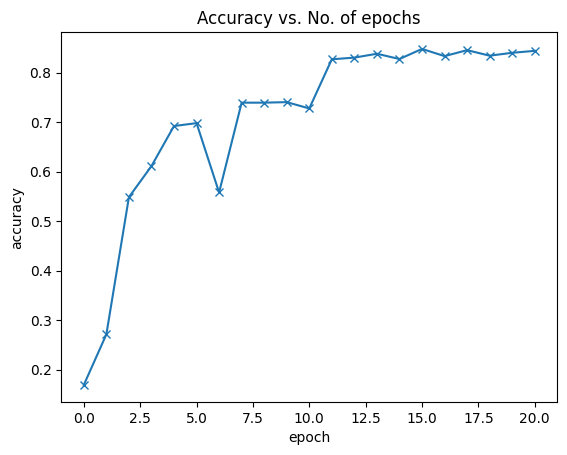

In [26]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
plot_accuracies(history)

In [27]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

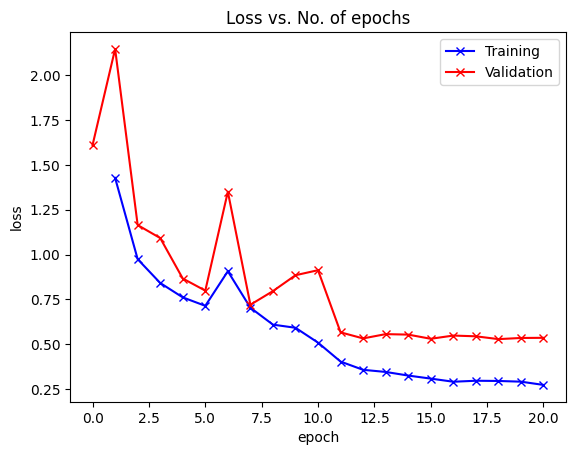

In [28]:
plot_losses(history)

In [29]:
def predict_image(img, model, classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

def show_image_prediction(img, label):
    plt.imshow(img.permute((1, 2, 0)))
    pred = predict_image(img, model, dataset.classes)
    print('Target:', dataset.classes[label])
    print('Prediction:', pred)

Target: dandelion
Prediction: dandelion


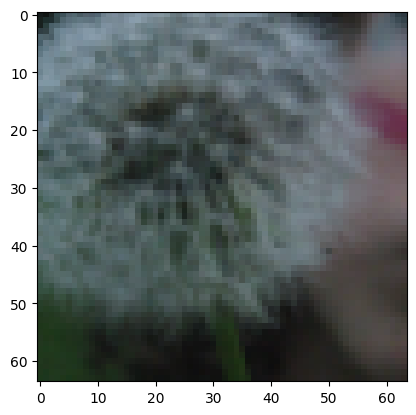

In [41]:
show_image_prediction(*valid_ds[10])

Target: rose
Prediction: rose


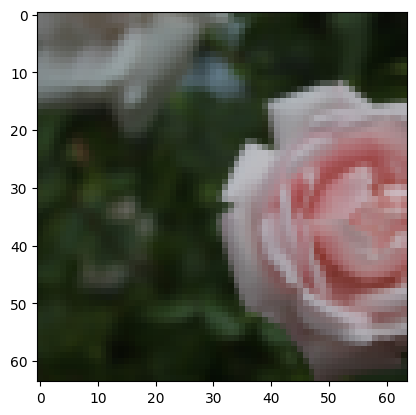

In [42]:
show_image_prediction(*valid_ds[250])

Target: daisy
Prediction: daisy


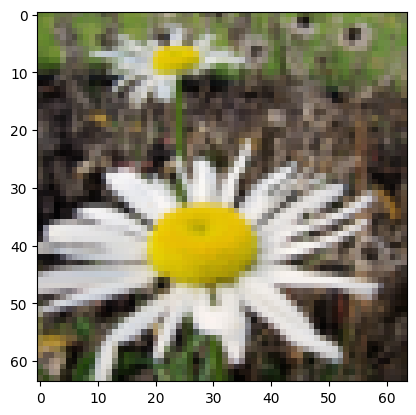

In [36]:
show_image_prediction(*valid_ds[180])

Target: dandelion
Prediction: dandelion


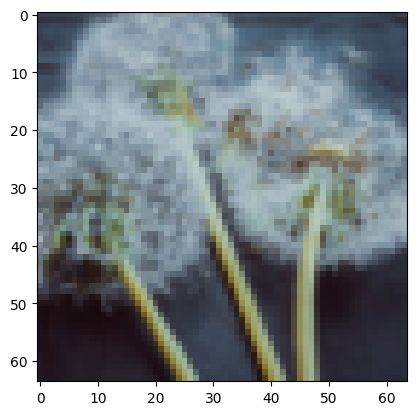

In [35]:
show_image_prediction(*valid_ds[198])

Target: tulip
Prediction: tulip


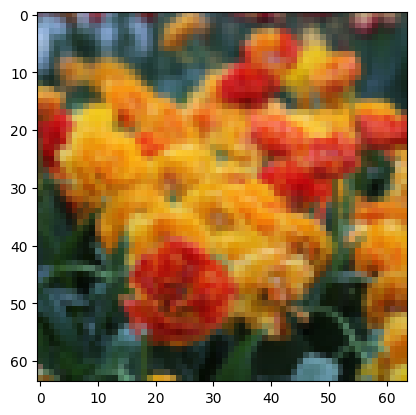

In [34]:
show_image_prediction(*valid_ds[23|8])